# M2 预测能力

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
data = pd.read_csv("m2_growth.csv", index_col="DateTime", parse_dates=True)
data.index.name = "datetime"
data.columns = ["btc_price", "m2_yoy", "m2_usd"]
data

,btc_price,m2_yoy,m2_usd
datetime,,,
2013-05-20,117.818636,5.565401,59166686473105
2013-05-27,126.392906,5.857141,59490171457382
2013-06-03,122.949188,6.767055,60072386054198
2013-06-10,104.357567,7.297086,60559839608422
2013-06-17,100.126305,6.508455,59754983891203
...,...,...,...
2025-06-09,110198.158714,8.153580,112305459146722
2025-06-16,107243.933346,8.306785,112280636517733
2025-06-23,105496.947495,8.211908,112798011931028


## 第一阶段：数据转换

In [16]:
# 删除不需要的列
data.drop(columns="m2_usd", inplace=True)

# 计算比特币价格的同比增长率 (BTC YoY Growth)
data["btc_yoy"] = (data["btc_price"] / data["btc_price"].shift(52) - 1) * 100

# 创建领先的M2同比增长率变量 (Lagged M2 YoY)
lags_to_create = [13, 26, 52]  # 定义要创建的领先周数

for lag in lags_to_create:
    data[f"m2_yoy_lag_{lag}w"] = data["m2_yoy"].shift(lag)

# 处理因计算而产生的缺失值
data_prepared = data.dropna()

data_prepared

,btc_price,m2_yoy,btc_yoy,m2_yoy_lag_13w,m2_yoy_lag_26w,m2_yoy_lag_52w
datetime,,,,,,
2014-05-19,447.404857,7.822699,279.740311,7.046719,5.640281,5.565401
2014-05-26,584.847975,7.735780,362.722153,7.521011,5.438644,5.857141
2014-06-02,663.505724,6.618120,439.658484,8.055573,5.736450,6.767055
2014-06-09,648.336322,5.935706,521.264316,7.780665,5.556449,7.297086
2014-06-16,590.567482,7.367577,489.822506,7.050502,5.357027,6.508455
...,...,...,...,...,...,...
2025-06-09,110198.158714,8.153580,58.636253,4.191925,1.558699,1.684414
2025-06-16,107243.933346,8.306785,61.308178,4.533524,1.018233,1.238470
2025-06-23,105496.947495,8.211908,75.072646,3.504038,0.068693,2.360032


## 第二阶段：探索数据分析

In [17]:
# 统一图表样式
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 7)

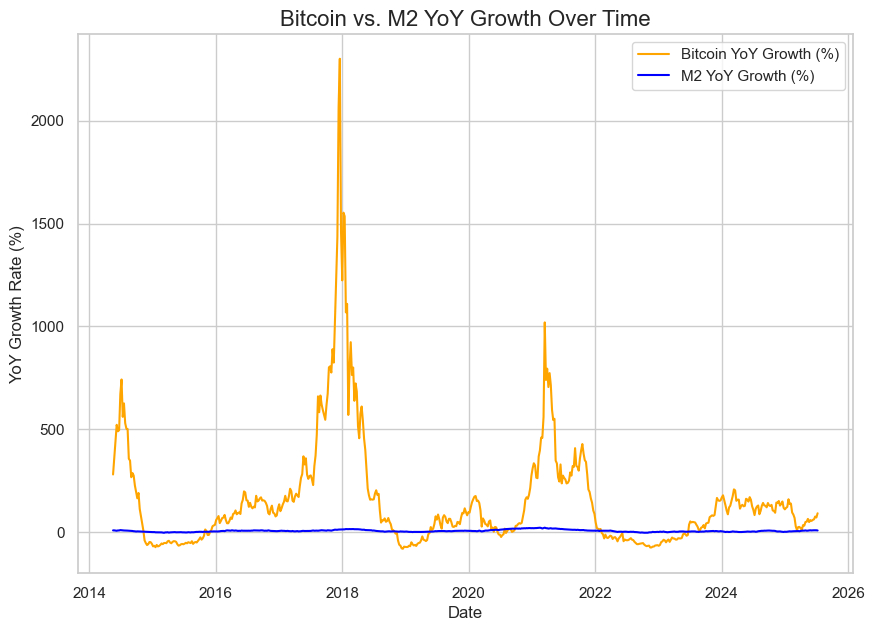

In [19]:
# 绘制时间序列图表，观察变量的关系

fig, ax = plt.subplots()

# 绘制比特币同比增长率 (btc_yoy)
sns.lineplot(
    data=data_prepared,
    x=data_prepared.index,
    y="btc_yoy",
    ax=ax,
    label="Bitcoin YoY Growth (%)",
    color="orange",
)

# 绘制M2同比增长率 (m2_yoy)
sns.lineplot(
    data=data_prepared,
    x=data_prepared.index,
    y="m2_yoy",
    ax=ax,
    label="M2 YoY Growth (%)",
    color="blue",
)

# 设置图表标题和标签
ax.set_title("Bitcoin vs. M2 YoY Growth Over Time", fontsize=16)
ax.set_ylabel("YoY Growth Rate (%)")
ax.set_xlabel("Date")
_ = ax.legend()

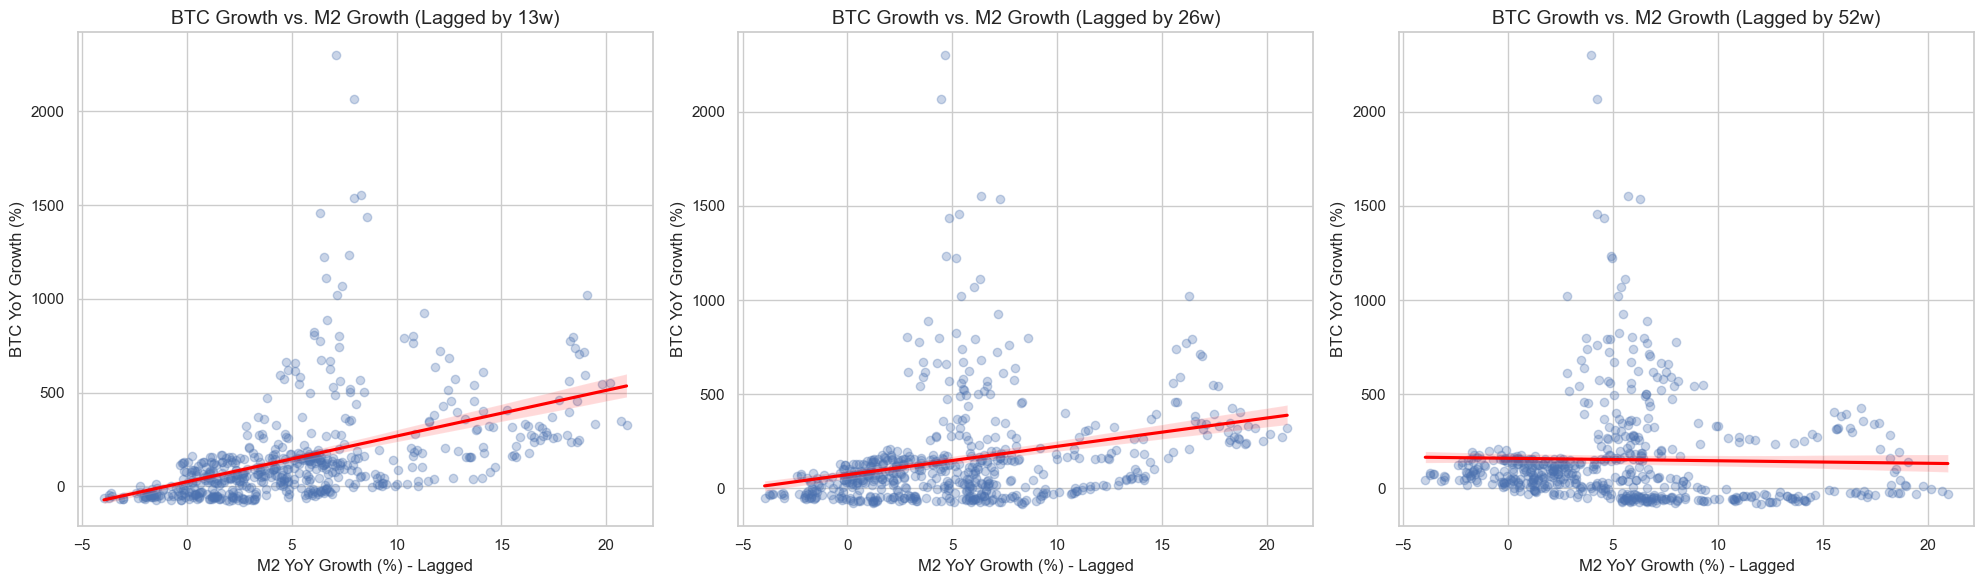

In [21]:
# 创建散点图，探索领先的M2增速与比特币增速的关系

# 我们将为每个领先时长（13周、26周、52周）创建一个散点图
# 使用 regplot 可以同时绘制散点和线性回归拟合线，更直观

# 定义我们在第一阶段创建的领先变量列名
lag_cols = [f"m2_yoy_lag_{lag}w" for lag in [13, 26, 52]]

# 创建一个 1x3 的子图网格
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, lag_col in enumerate(lag_cols):
    sns.regplot(
        data=data_prepared,
        x=lag_col,
        y="btc_yoy",
        ax=axes[i],
        scatter_kws={"alpha": 0.3},  # 让点半透明，以观察重叠情况
        line_kws={"color": "red"},
    )  # 让拟合线为红色
    axes[i].set_title(
        f'BTC Growth vs. M2 Growth (Lagged by {lag_col.split("_")[-1]})', fontsize=14
    )
    axes[i].set_xlabel(f"M2 YoY Growth (%) - Lagged")
    axes[i].set_ylabel("BTC YoY Growth (%)")

# 优化布局，防止标题重叠
plt.tight_layout()

In [23]:
# # 计算并可视化相关系数矩阵

# # 选择我们关心的列
# columns_of_interest = ["btc_yoy"] + lag_cols
# correlation_matrix = data_prepared[columns_of_interest].corr()

# # 打印相关系数矩阵，直接查看数值
# print(correlation_matrix)

# # 使用热力图 (heatmap) 来可视化相关系数矩阵
# plt.figure(figsize=(8, 6))
# sns.heatmap(
#     correlation_matrix,
#     annot=True,  # 在格子上显示数值
#     cmap="coolwarm",  # 使用冷暖色调（正相关为暖色，负相关为冷色）
#     fmt=".2f",
# )  # 格式化数值为两位小数
# plt.title("Correlation Matrix: BTC Growth vs. Lagged M2 Growth", fontsize=16)
# plt.show()

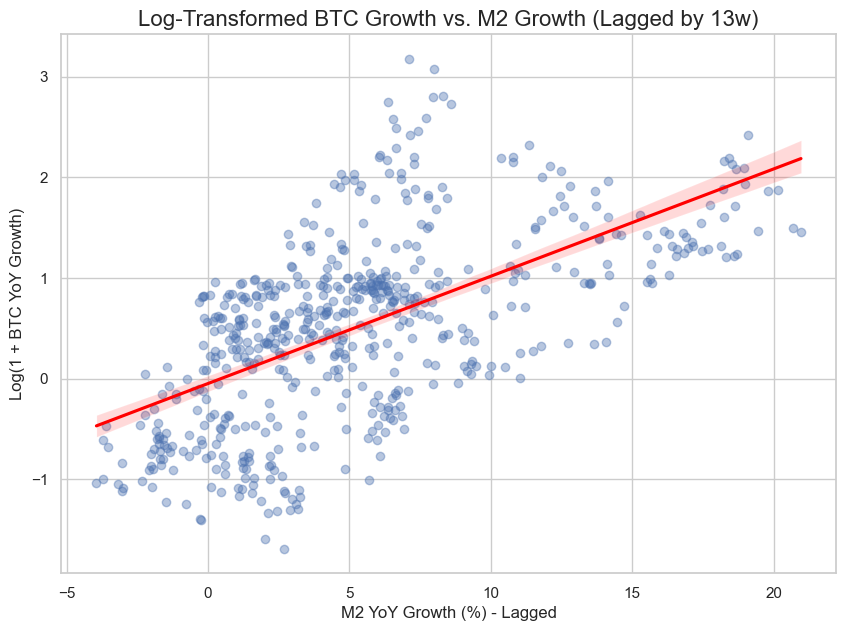

In [26]:
# --- 对因变量进行对数转换 ---

# 为了避免对负数或零取对数（btc_yoy可能为负），我们使用 log(1 + x) 的形式。
# 首先，将百分比形式的 btc_yoy 转换回小数形式 (例如 50% -> 0.5)
# 然后，计算 log(1 + btc_yoy_decimal)
# 这个值被称为对数回报率 (log return)，在金融中非常常用。
data_prepared.loc[:, "log_btc_yoy"] = np.log1p(data_prepared["btc_yoy"] / 100)

# 重新绘制散点图，验证转换效果

best_lag_col = "m2_yoy_lag_13w"

# 使用 regplot 绘制散点和回归线
sns.regplot(
    data=data_prepared,
    x=best_lag_col,
    y="log_btc_yoy",
    scatter_kws={"alpha": 0.4},
    line_kws={"color": "red"},
)

# 设置标题和标签
plt.title("Log-Transformed BTC Growth vs. M2 Growth (Lagged by 13w)", fontsize=16)
plt.xlabel("M2 YoY Growth (%) - Lagged")
plt.ylabel("Log(1 + BTC YoY Growth)")
plt.grid(True)
plt.show()

## 第三阶段：回归模型

$$log(1 + btc\_yoy/100) = \beta_0 + \beta_1 * m2\_yoy\_lag\_13w$$

如何解读斜率系数？

自变量X每增加一个单位，因变量Y大约会发生$(100*\beta_1)\%$的百分比变化。

In [28]:
import statsmodels.api as sm
import statsmodels.formula.api as smf  # 使用公式API，更直观

# --- 步骤 1: 定义并拟合回归模型 ---

# 我们使用 statsmodels 的公式API，语法非常类似R语言，清晰易读
# 公式 'y ~ x' 表示我们想要用 x 来预测 y
# 'log_btc_yoy' 是我们的因变量 (y)
# 'm2_yoy_lag_13w' 是我们的自变量 (x)
formula = "log_btc_yoy ~ m2_yoy_lag_13w"

# 使用 OLS (Ordinary Least Squares) 普通最小二乘法建立模型
# smf.ols 会根据公式和数据自动处理截距项
model = smf.ols(formula=formula, data=data_prepared)

# .fit() 方法执行实际的回归计算
results = model.fit()

# --- 步骤 2: 显示并解读模型结果 ---

print("========= OLS Regression Results =========")
print(results.summary())
print("==========================================")

# --- 步骤 3: 提取关键系数并进行预测演示 ---

# 从结果中提取截距 (β₀) 和斜率 (β₁)
beta_0 = results.params["Intercept"]
beta_1 = results.params["m2_yoy_lag_13w"]

print("\n--- 模型系数解读 ---\n")
print(f"回归方程为: log_btc_yoy = {beta_0:.4f} + {beta_1:.4f} * m2_yoy_lag_13w")
print(f"斜率系数 (β₁) 为 {beta_1:.4f}。")
print(
    f"领先13周的M2同比增速每增加1个百分点, 比特币的对数同比增长率预计增加 {beta_1:.4f}。"
)
print(f"换算成百分比效应，比特币的同比增长率预计会增长约 {beta_1*100:.2f}%。")

# 演示如何用模型进行预测
# 假设我们想预测当领先13周的M2增速为 5% 时的情况
m2_scenario = 5

# 1. 计算预测的对数值
predicted_log_value = beta_0 + beta_1 * m2_scenario

# 2. 将对数值转换回实际的百分比增长率
predicted_btc_yoy = (np.exp(predicted_log_value) - 1) * 100

print("\n--- 预测示例 ---")
print(f"当领先13周的M2增速为 {m2_scenario}% 时:")
print(f"  1. 模型预测的对数同比增长率为: {predicted_log_value:.4f}")
print(
    f"  2. 将其转换回实际百分比，预测的比特币年同比增长率为: {predicted_btc_yoy:.2f}%"
)

========= OLS Regression Results =========
                            OLS Regression Results                            
Dep. Variable:            log_btc_yoy   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     329.7
Date:                Tue, 15 Jul 2025   Prob (F-statistic):           1.28e-58
Time:                        17:21:45   Log-Likelihood:                -638.49
No. Observations:                 579   AIC:                             1281.
Df Residuals:                     577   BIC:                             1290.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
I

## 第四阶段：报告

#### 核心发现

领先13周的M2同比增长率能够预测比特币价格变化，这种关系具备统计显著性。

#### 量化关系

1. `m2_yoy_lag_13w` 的 **P值为0.000**，远低于0.05的传统显著性水平。这表明M2增速与比特币增长率之间的正相关关系是**高度统计显著的**，极不可能是由随机因素造成的。

2. 模型的斜率系数为 **0.1066**。领先13周的M2同比增长率**每增加1个百分点**，比特币的年化对数回报率预计将增加0.1066。换算成更直观的百分比效应，即比特币的年同比增长率预计会因此**增长约10.66%**。

3. 模型的 **R-squared值为0.364**。这意味着，领先13周的M2同比增长率这一个变量，可以解释比特币对数同比增长率约36.4%的波动。这是一个相当可观的解释力，证实了M2增速是一个重要的宏观影响因素。

#### 研究的局限性与结论

1.  **相关不等于因果:** 虽然我们发现了强大的预测关系，但这不直接证明是M2增长*导致*了比特币上涨。两者可能都受更广泛的宏观环境（如低利率、市场风险偏好）驱动。
2.  **解释力有限:** 模型解释了36.4%的变动，意味着仍有**超过60%的波动是由其他因素引起**的，例如技术创新、监管政策、市场情绪等。
3.  **模型诊断警示:** Durbin-Watson统计值（0.050）远低于理想值（接近2），暗示模型残差存在**严重的序列自相关**。这虽然不影响系数的点估计，但可能使得我们对系数显著性的判断过于乐观。在未来的研究中，应使用考虑时间序列自相关的模型（如ARIMAX）进行优化。